# Obesity Prediction ML models

CS4422 - DATA CENTRIC COMPUTING
Group Members: Naem Haq, Aaron McGuiness, Dara Heaphy, Thomas Joyce. 

Analysis Objective: Forecast the obesity classification for an individual.
Dataset: Estimation of obesity levels based on eating habits and physical condition in individuals, collated by Palechor & Manotas (Universidad de la Costa).

Features: 17 features.


# Import Statements & read csv

In [13]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split  # aaron said 80 20
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import warnings
!pip install lightgbm
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier




df = pd.read_csv('ObesityDataSet.csv')

# Overview of dataset

In [18]:
df.head()



,Gender,Age,Height,Weight,family_history_with_overweight,eat_high_caloric_food,eat_vegetables_frequency,main_meals_day,eat_between_meals,smoke,water_day,monitor_calories,exercise_frequency,device_time,drink_alcohol,transport_mode,obese_category,null_count
0,Female,21,1.62,64,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight,0
1,Female,21,1.52,56,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight,0
2,Male,23,1.80,77,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight,0
3,Male,27,1.80,87,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I,0
4,Male,22,1.78,90,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II,0


In [48]:
df.info(verbose=True, show_counts=True)
print('summary')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   int64  
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   int64  
 4   family_history_with_overweight  2111 non-null   object 
 5   eat_high_caloric_food           2111 non-null   object 
 6   eat_vegetables_frequency        2111 non-null   int64  
 7   main_meals_day                  2111 non-null   int64  
 8   eat_between_meals               2111 non-null   object 
 9   smoke                           2111 non-null   object 
 10  water_day                       2111 non-null   int64  
 11  monitor_calories                2111 non-null   object 
 12  exercise_frequency              21

# Preprocessing and Data Cleaning (01)

In [106]:
#PREPROCESSING 01
# In Excel, we renamed the columns and also converted some floats to integers as pre-processing

#THIS DOES NOT WORK



subset_columns = ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'eat_high_caloric_food', 'eat_vegetables_frequency', 'main_meals_day',
       'eat_between_meals', 'smoke', 'water_day', 'monitor_calories',
       'exercise_frequency', 'device_time', 'drink_alcohol', 'transport_mode',
       'obese_category']  

# Step 1: Calculate the number of columns with identical values for each row
identical_columns_count = (df == df.iloc[:, 0]).sum(axis=1)

# Step 2: Filter the DataFrame to select rows where the count of identical columns is greater than 10
rows_to_delete = identical_columns_count > 10

# Step 3: Delete the selected rows from the DataFrame
df_filtered = df[~rows_to_delete]

# Optional: If you want to reset index after deletion
df_filtered.reset_index(drop=True, inplace=True)

# Display the modified DataFrame
print(df_filtered)





      Gender  Age  Height  Weight family_history_with_overweight  \
0     female   21    1.62      64                            yes   
1     female   21    1.52      56                            yes   
2       male   23    1.80      77                            yes   
3       male   27    1.80      87                             no   
4       male   22    1.78      90                             no   
...      ...  ...     ...     ...                            ...   
2106  female   21    1.71     131                            yes   
2107  female   22    1.75     134                            yes   
2108  female   23    1.75     134                            yes   
2109  female   24    1.74     133                            yes   
2110  female   24    1.74     133                            yes   

     eat_high_caloric_food  eat_vegetables_frequency  main_meals_day  \
0                       no                         2               3   
1                       no             

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'eat_high_caloric_food', 'eat_vegetables_frequency', 'main_meals_day',
       'eat_between_meals', 'smoke', 'water_day', 'monitor_calories',
       'exercise_frequency', 'device_time', 'drink_alcohol', 'transport_mode',
       'obese_category', 'null_count'],
      dtype='object')


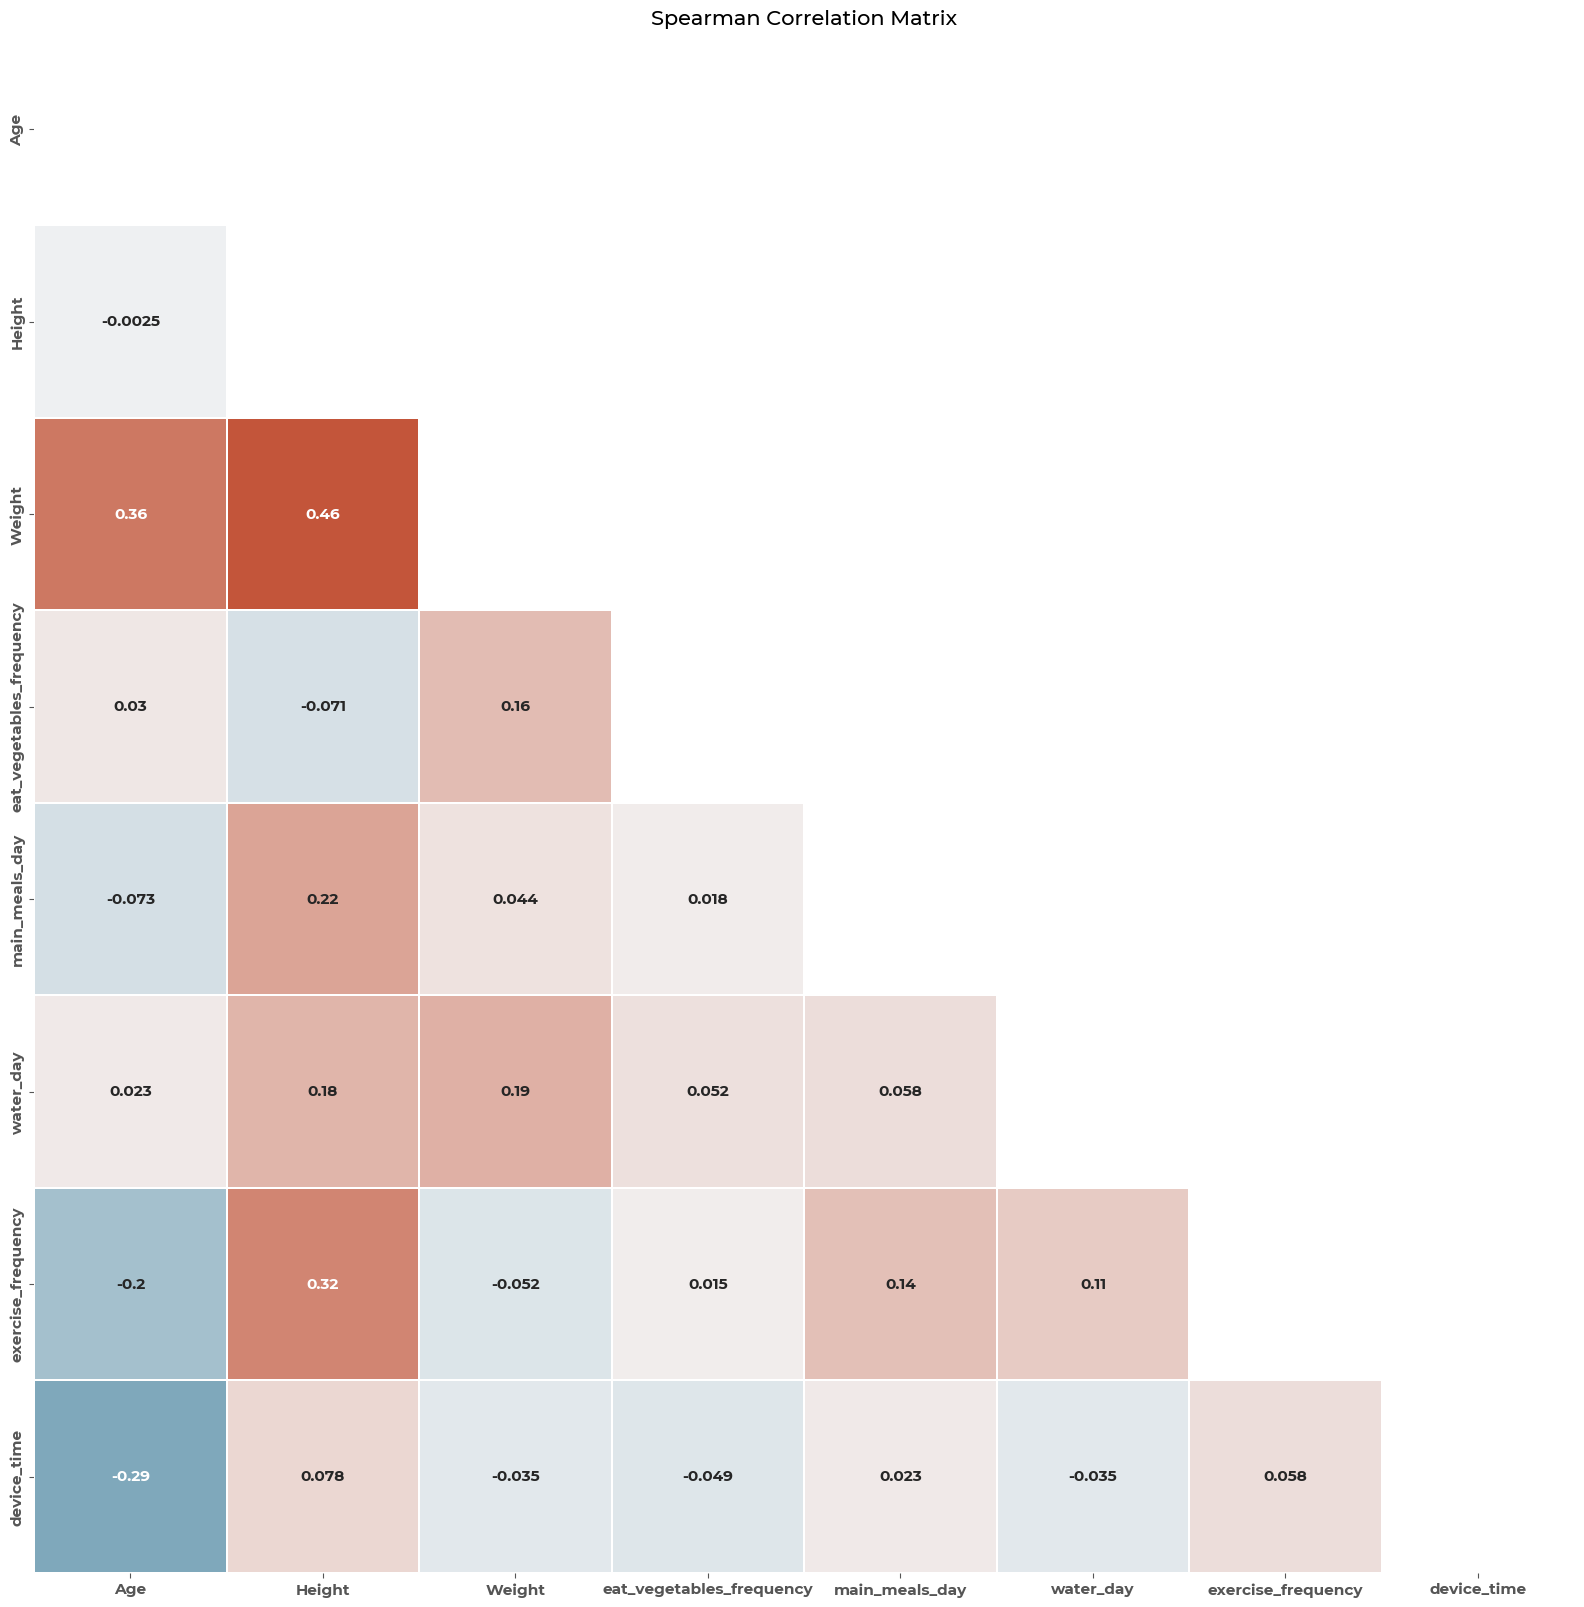

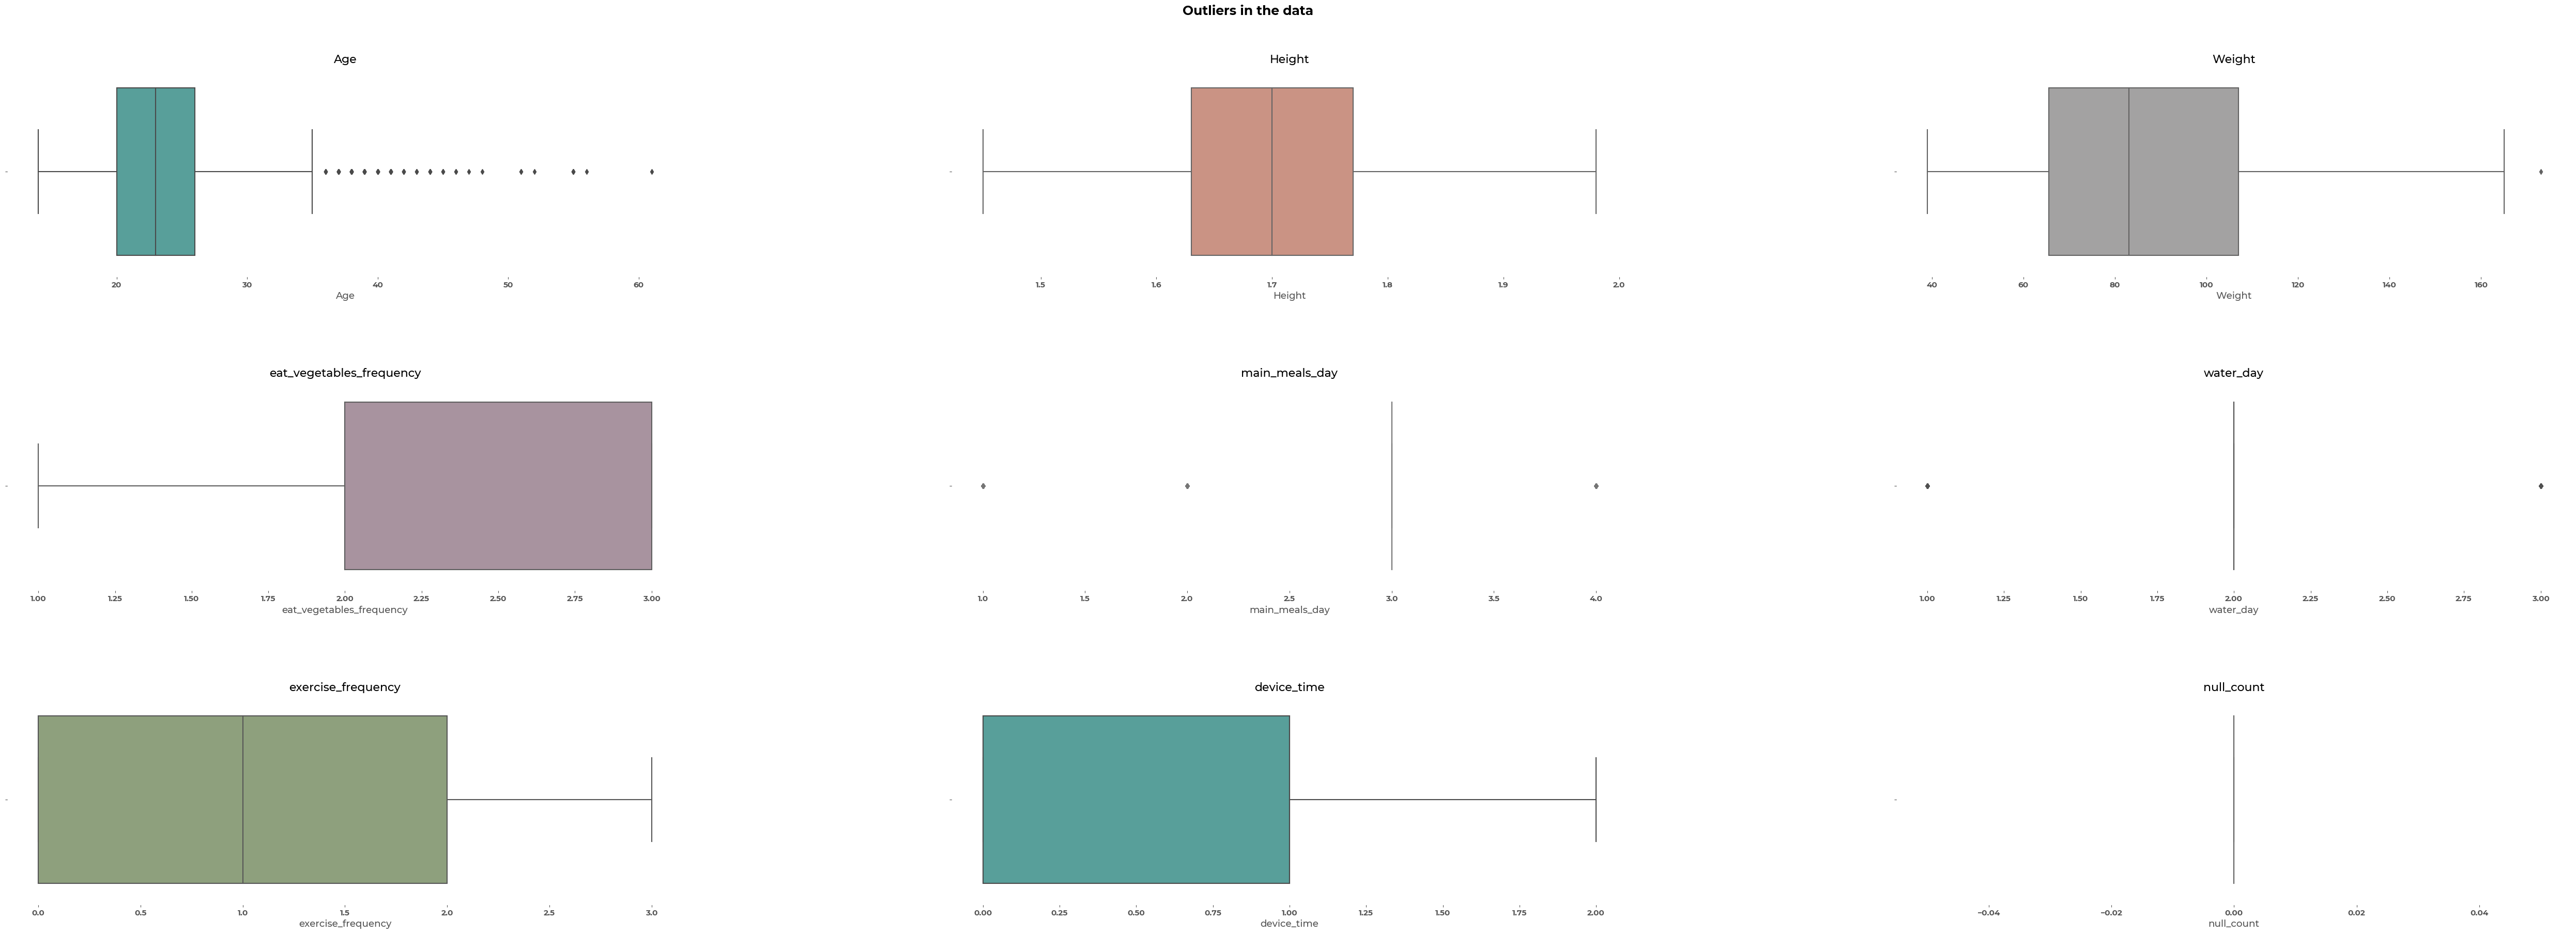

In [87]:

df["null_count"] = df.isnull().sum(axis=1)
raw_counts = df.groupby("null_count").size().to_dict()
counts = [v for _, v in raw_counts.items()]
labels = ["{} Null Value(s)".format(k) for k, _ in raw_counts.items()]

fig = make_subplots(
    rows=1, 
    cols=1, 
    subplot_titles=["Null Values Distribution"], 
    specs=[[{'type': 'pie'}]]
)

fig.add_trace(go.Pie(labels=labels, values=counts, hole=0.2), row=1, col=1)
fig.update_traces(textposition='outside', textinfo='percent+value+label', insidetextorientation='horizontal')
fig.update_layout(
    showlegend=False, 
    width=800,
    height=500,
)
fig.show()

print(df.columns)


df2 = df.copy()

features = [
    'Age', 'Height', 'Weight',
    'eat_vegetables_frequency', 'main_meals_day',
    'water_day', 
    'exercise_frequency', 'device_time'
]

cat_features = [
    "Gender", "family_history_with_overweight", 'eat_high_caloric_food',  'eat_between_meals',
    'smoke', 'monitor_calories','drink_alcohol', 'transport_mode',
    'obese_category'
]

for feature in cat_features:
    le = LabelEncoder()
    df2[feature] = le.fit_transform(df2[feature])
    
correlation_matrix = df2[features].corr(method="spearman")

f, ax = plt.subplots(figsize=(20, 20))  # Corrected import statement
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Spearman Correlation Matrix", fontsize=15)


colors = ["#4caba4", "#d68c78", "#a3a2a2", "#ab90a0", "#e6daa3", "#6782a8", "#8ea677", "#4caba4", "#d68c78", "#a3a2a2", "#ab90a0", "#e6daa3", "#6782a8", "#8ea677", "#4caba4", "#d68c78", "#a3a2a2", "#ab90a0", "#e6daa3", "#6782a8", "#8ea677"]

numeric_columns = df.select_dtypes(include=['float64', 'int64'])
fig = plt.figure(figsize=[64,20])
plt.suptitle('Outliers in the data', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(numeric_columns):
    ax = fig.add_subplot(3,3, i+1);
    ax = sns.boxplot(data = df, x=col ,  color= colors[i]);
    ax.set_title(f'{col}')
    ax.set_xlabel(f'{col}')
    ax.grid(False)
plt.show()
#outliers only present in age, not in rest

# Data Visualisation / Charts (02)

In [67]:
df = pd.read_csv("ObesityDataSet.csv")
print('Original Rows:',df.shape[0])
print('Original Columns:',df.shape[1])
X = df.drop(columns=['obese_category'])  # 'obesity_level' is our target variable
y = df['obese_category']

# Splits the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#check shape of data without obese category
print('\nTrain Set Rows:',X_train.shape[0])
print('Train Set Columns:',X_train.shape[1])

Original Rows: 2111
Original Columns: 17

Train Set Rows: 1688
Train Set Columns: 16


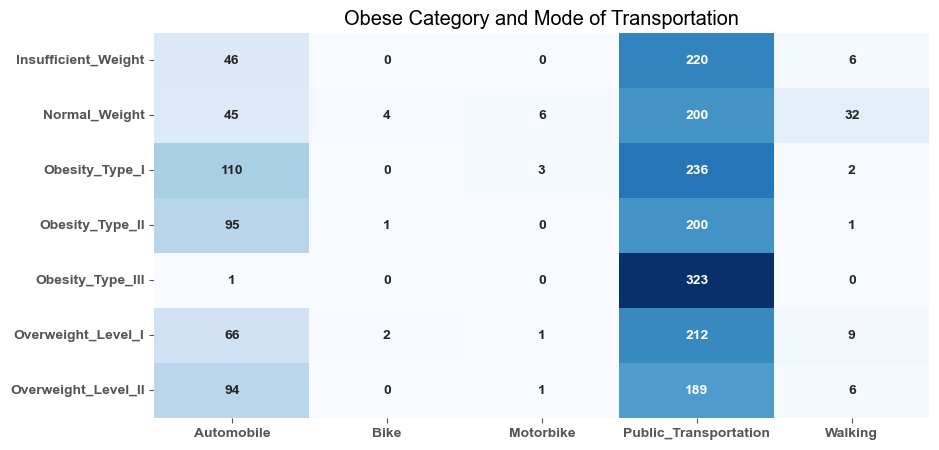

In [77]:
#Observation on Transport Mode and Weight, Cross Chart

cross_tab = pd.crosstab(df['obese_category'], df['transport_mode'])
plt.figure(figsize=(10, 5))
plt.rcParams['font.family'] = 'Arial'
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Obese Category and Mode of Transportation')
plt.xlabel('')
plt.ylabel('')
plt.show()
#Obesity_Type II or Type III people do not or rarely walk or use bike which shows lack of physical activity


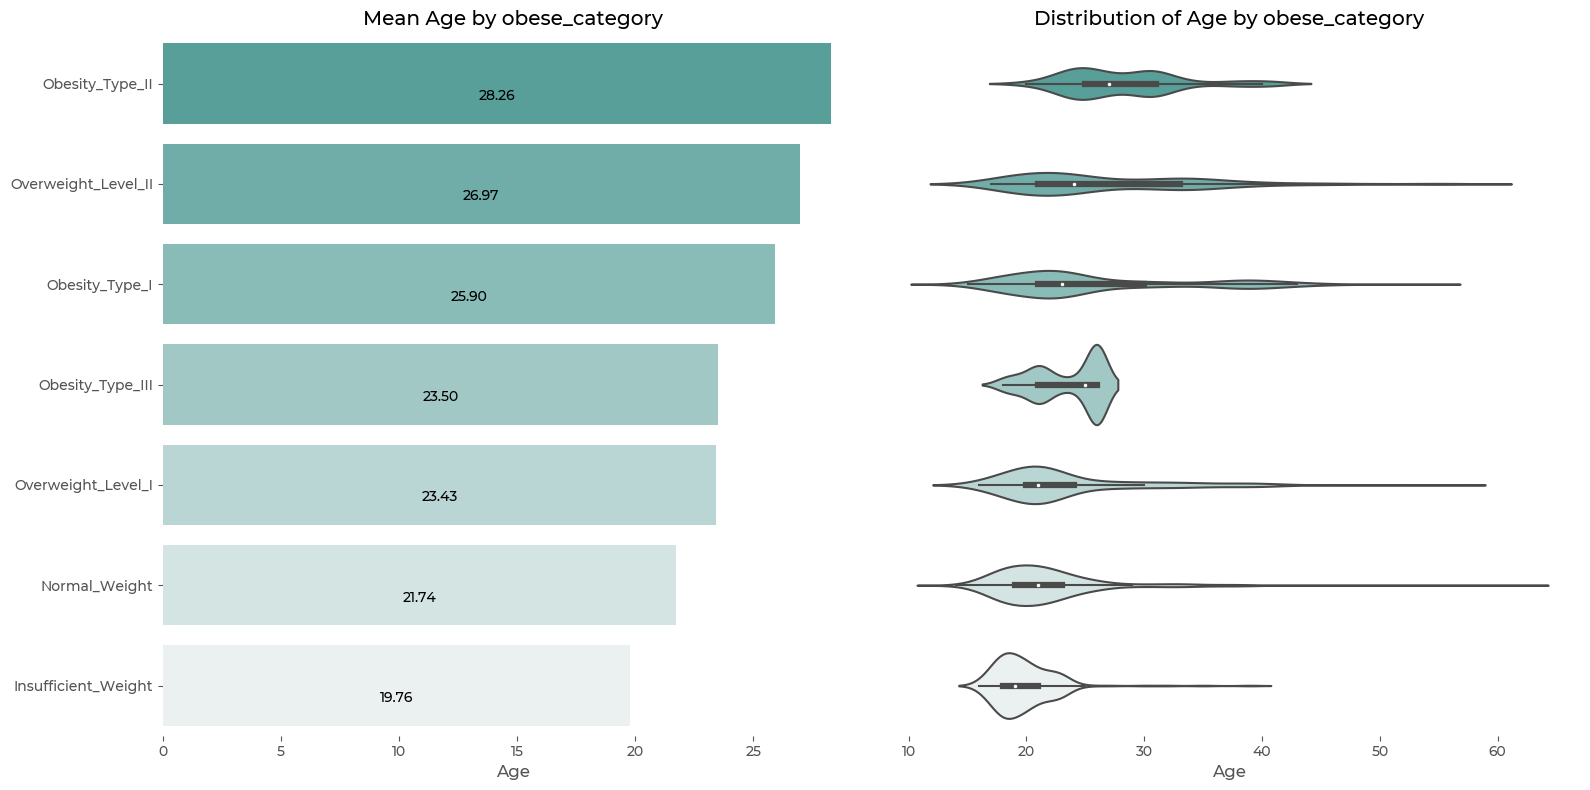

In [26]:
#Observation on Age and Weight, Bar Chart & Violin Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1 = axes[0]
df_sort = df.groupby('obese_category')['Age'].mean().sort_values(ascending=False).index
sns.barplot(x='Age', y='obese_category', data=df, palette='light:#4caba4_r', order=df_sort,
            estimator=np.mean, ci=None, errwidth=0, ax=ax1)
for p in ax1.patches:
    ax1.annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height()),
                ha='center', va='center', xytext=(0, 20), textcoords='offset points', fontsize=10, color='black')
ax1.set_title('Mean Age by obese_category')
ax1.set_xlabel('Age')
ax1.set_ylabel('')
sns.despine(left=True, bottom=True, ax=ax1)

# Violin Plot
ax2 = axes[1]
sns.violinplot(x='Age', y='obese_category', data=df, palette='light:#4caba4_r', order=df_sort, ax=ax2)
ax2.set_title('Distribution of Age by obese_category')
ax2.set_ylabel("")
plt.yticks([])
sns.despine(left=True, bottom=True, ax=ax2)
plt.tight_layout()
plt.show()
#Normal Weight or Insufficient weight people seems to be yonger on an average than the rest

 Age, height and Weight are normally distributed with some skewness


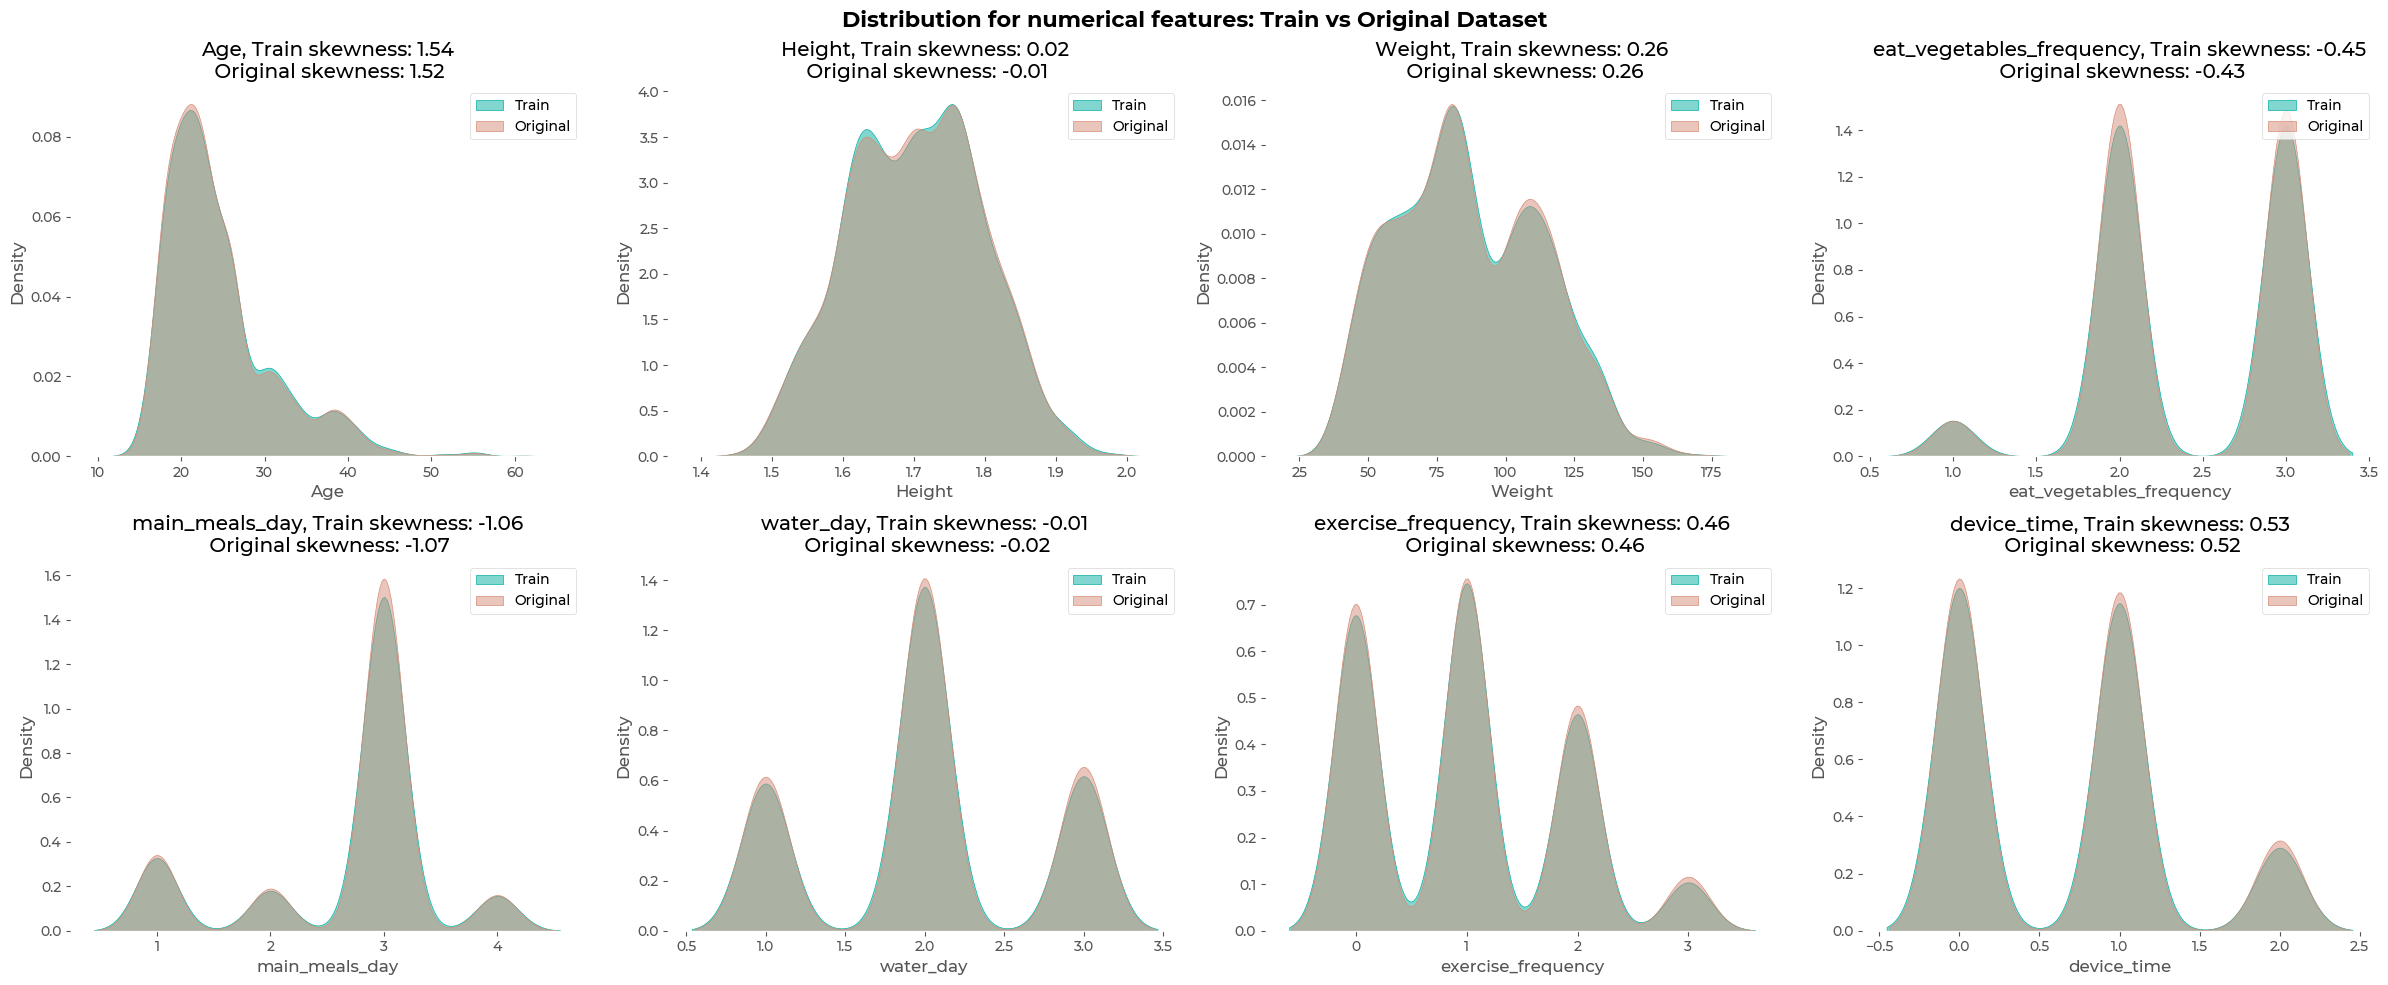

In [30]:
#Exploration of Data with Kernel Density Estimation (KDE) plots

# Checking for distributions
numeric_columns = X_train.select_dtypes(include=['float64', 'int64'])

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.family'] = 'Montserrat'
plt.rcParams['text.color'] = 'black'
    
def dist(train_dataset, original_dataset, columns_list, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(24, 10))
    plt.suptitle('Distribution for numerical features: Train vs Original Dataset', fontsize=16, fontweight='bold')
    axs = axs.flatten()
    
    for i, col in enumerate(columns_list):
        sns.kdeplot(train_dataset[col], ax=axs[i], fill=True, alpha=0.5, linewidth=0.5, color='#05b0a3', label='Train')
        sns.kdeplot(original_dataset[col], ax=axs[i], fill=True, alpha=0.5, linewidth=0.5, color='#d68c78', label='Original')
        axs[i].set_title(f'{col}, Train skewness: {train_dataset[col].skew():.2f}\n Original skewness: {original_dataset[col].skew():.2f}')
        axs[i].legend()
        
    plt.tight_layout()
    
dist(train_dataset=X_train, original_dataset=df, columns_list=numeric_columns.columns, rows=2, cols=4)

print(' Age, height and Weight are normally distributed with some skewness')

In [78]:
#function to plot pie charts used below
def showplot(columnname):
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['font.family'] = 'Montserrat'
    plt.rcParams['text.color'] = 'black'
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax = ax.flatten()
    value_counts = df[columnname].value_counts()
    labels = value_counts.index.tolist()
    colors = ["#2f042e", "#d668f4", "#c136ff", "#a826db", "#9614b5", "#810090", "#6b0066"]
    
    wedges, texts, autotexts = ax[0].pie(
        value_counts, autopct='%1.1f%%',textprops={'size': 9, 'color': 'white','fontweight':'bold' }, colors=colors,
        wedgeprops=dict(width=0.35),  startangle=80,   pctdistance=0.85  )
    centre_circle = plt.Circle((0, 0), 0.6, fc='white')
    ax[0].add_artist(centre_circle)
    
    sns.countplot(data=df, y=columnname, ax=ax[1], palette=colors, order=labels)
    for i, v in enumerate(value_counts):
        ax[1].text(v + 5, i, str(v), color='black', fontsize=10, ha='left', va='center')  # Adjusted text position    sns.despine(left=True, bottom=True)
    plt.yticks(fontsize=9, color='black')
    ax[1].set_ylabel(None)
    plt.xlabel("")
    plt.xticks([])
    fig.suptitle(columnname, fontsize=15, fontweight='bold', x=0.44)  # Center the title
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


Largest segment is Obesity_Type_I with a share of 16.6%
This is the chart for obese_category


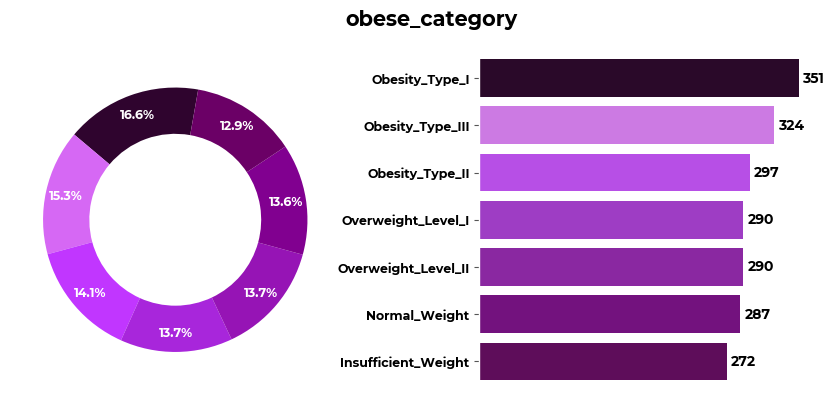

This is the chart for Gender


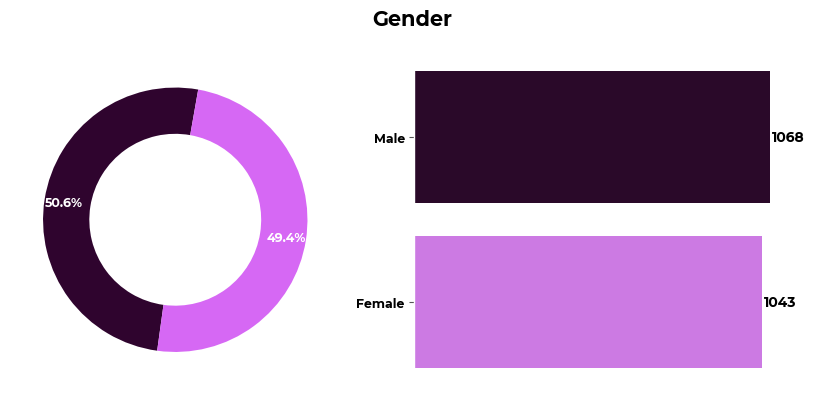

This is the chart for eat_high_caloric_food


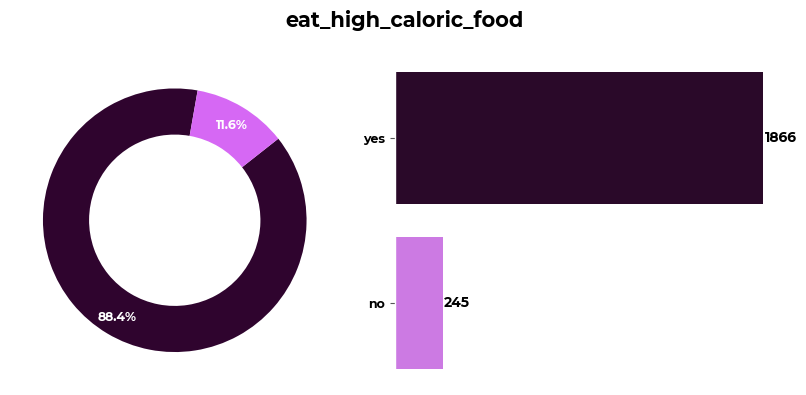

This is the chart for eat_vegetables_frequency


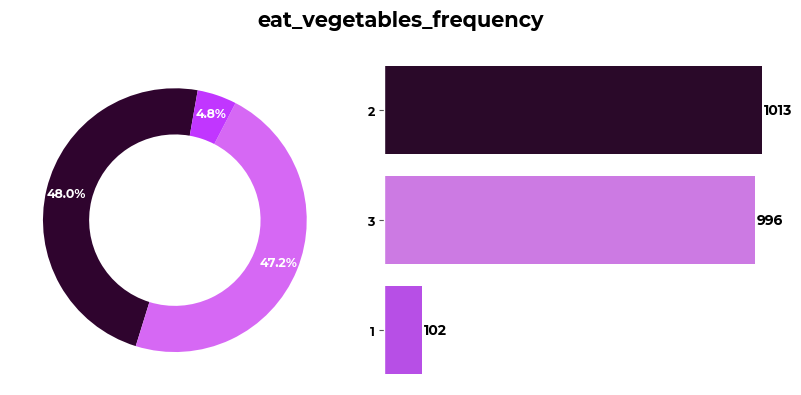

This is the chart for main_meals_day


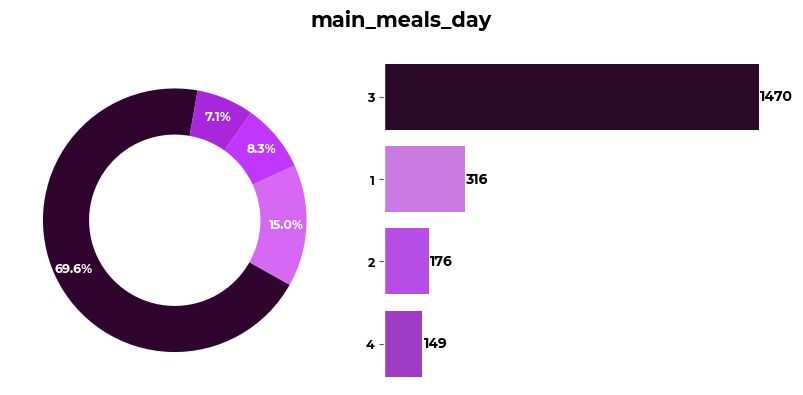

This is the chart for eat_between_meals


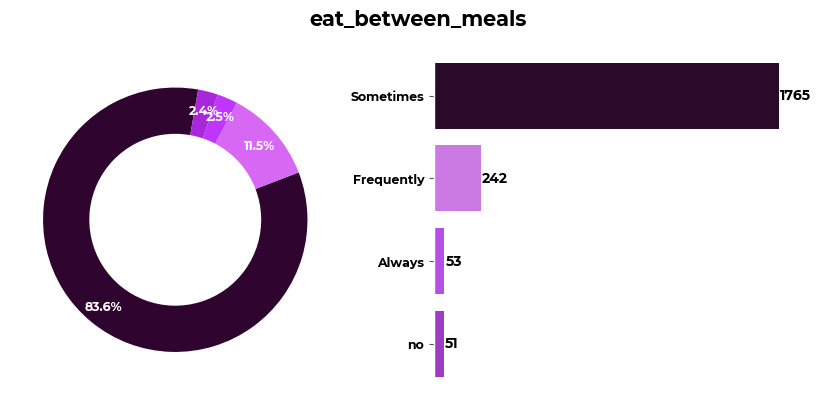

This is the chart for water_day


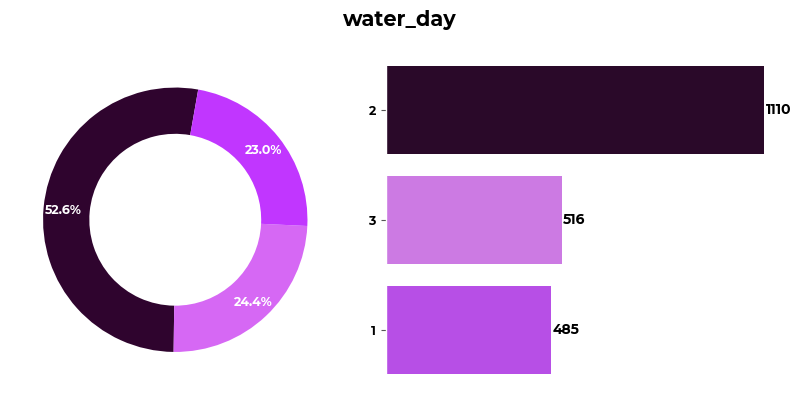

This is the chart for monitor_calories


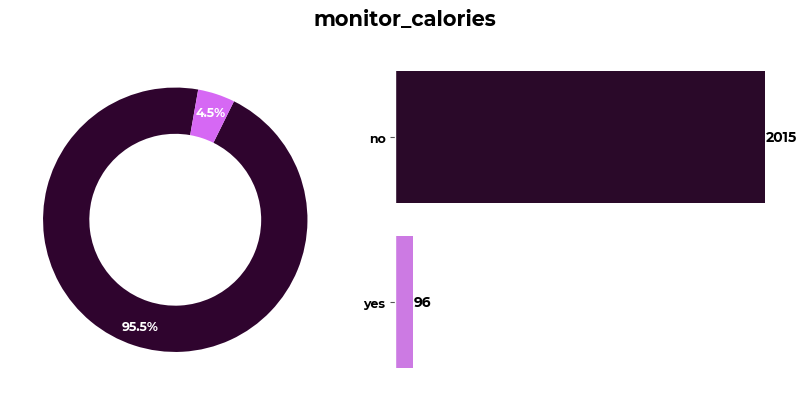

This is the chart for exercise_frequency


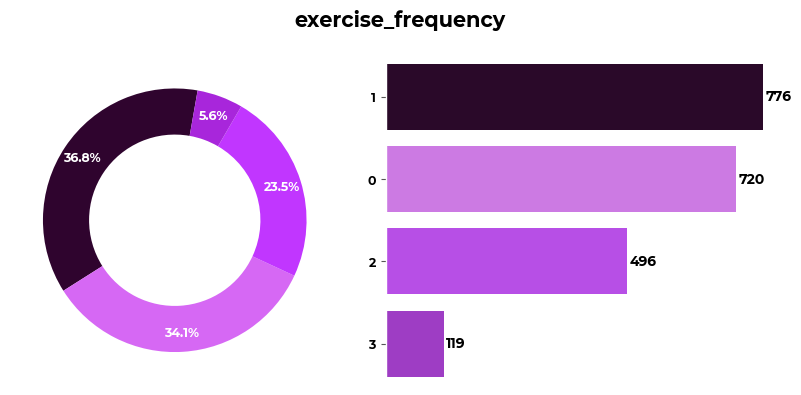

This is the chart for device_time


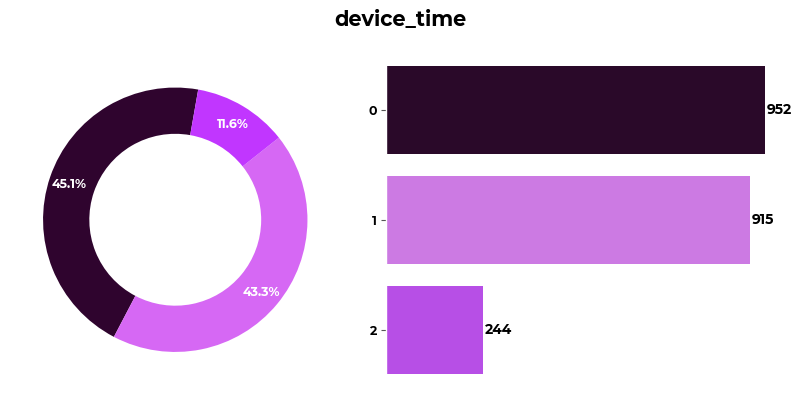

This is the chart for drink_alcohol


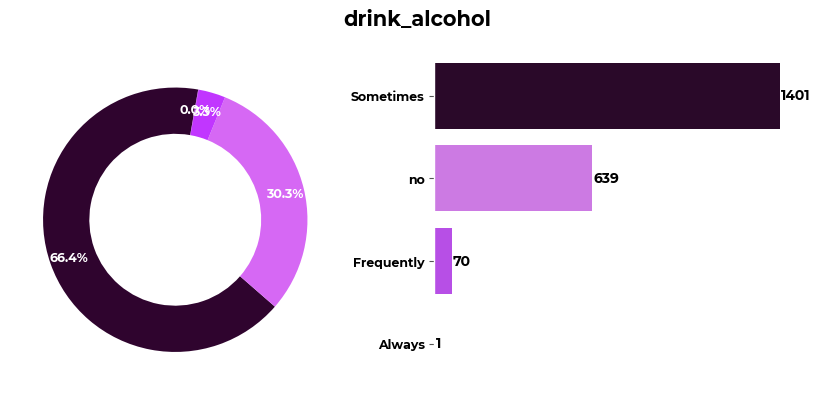

This is the chart for transport_mode


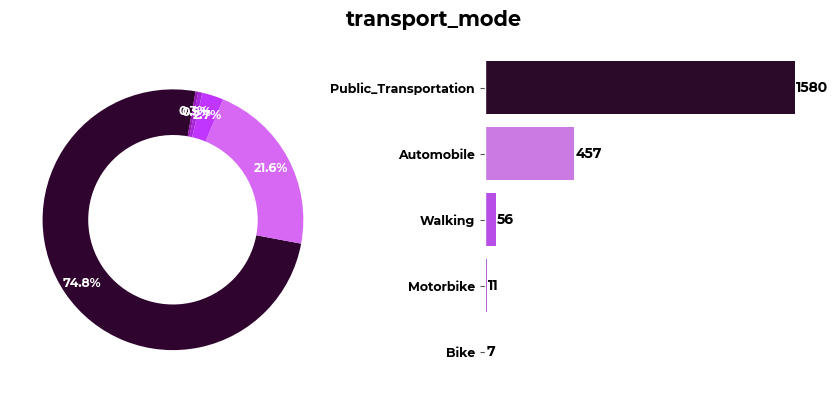

In [85]:
print('Largest segment is Obesity_Type_I with a share of 16.6%')

columns = ['obese_category', 'Gender', 'eat_high_caloric_food', 'eat_vegetables_frequency', 'main_meals_day',
       'eat_between_meals', 'water_day', 'monitor_calories',
       'exercise_frequency', 'device_time', 'drink_alcohol', 'transport_mode']

for col in columns:
    print('This is the chart for ' + col)
    showplot(col)


# Multi-Layer Perceptron ML Model (03)
This is important one

In [ ]:

#MULTI LAYER PERCEPTRON TOM VIP


warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


# Keep only the desired columns
desired_columns = ['Height', 'Weight', 'eat_vegetables_frequency', 'exercise_frequency','water_day','Age','device_time', 'Gender',
                   'family_history_with_overweight', 'eat_high_caloric_food', 'eat_between_meals', 'smoke', 'monitor_calories', 'transport_mode']
data = data[desired_columns + ['obese_category']]  # Add 'obese_category' to keep it as well

# Apply label encoding to 'obese_category'
label_encoder = LabelEncoder()
data['obese_category'] = label_encoder.fit_transform(data['obese_category'])

# Extract features and target variable
tr_features = data.drop(columns=['obese_category'])  # Features
tr_labels = data['obese_category']  # Target variable

# Define the columns to one-hot encode
nominal_columns = ['Gender', 'family_history_with_overweight', 'eat_high_caloric_food', 
                   'eat_between_meals', 'smoke', 'monitor_calories', 'transport_mode']

# Create a pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), nominal_columns)
    ],
    remainder='passthrough'
)

# Define the MLP model
mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier())
])

# Define the parameters for grid search
parameters = {
    'classifier__hidden_layer_sizes': [(10,), (50, 10), (100,)],
    'classifier__activation': ['relu', 'tanh', 'logistic'],
    'classifier__learning_rate': ['constant'],
    'classifier__learning_rate_init': [0.01, 0.5, 0.1, 0.2],
    'classifier__max_iter': [7000],
    'classifier__solver': ['adam']
}

# Perform grid search
cv = GridSearchCV(mlp, parameters, cv=5)
cv.fit(tr_features, tr_labels)

# Print results
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))
    
    mean = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(mean, stds, results.cv_results_['params']):
        print('{} (+/- {}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

print_results(cv)


# LGBM Classifier (04)

In [1]:
%pip install lightgbm

# Load necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('datasets/train.csv')



Note: you may need to restart the kernel to use updated packages.


In [2]:
# Split features and target variable
X = df.drop(columns=['obese_category'])
y = df['obese_category']

# Apply label encoding to the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Apply one-hot encoding to categorical features if needed
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [3]:
# Initialize LGBM classifier with the best parameters
best_params = {
    "objective": "multiclass",
    "metric": "multi_logloss",  
    "verbosity": -1,            #verbosity is used to set the logging level during model training and validation process.
    "boosting_type": "gbdt",    
    "random_state": 42,
    "num_class": 7,
    'learning_rate': 0.04,
    'n_estimators': 500,
    'lambda_l1': 0.01,          #lambda_l1 is L1 regularization
    'lambda_l2': 0.04,          #lambda_l2 is L2 regularization
    'max_depth': 10,
    'colsample_bytree': 0.41,   #colsample_bytree is the subsample ratio of columns when constructing each tree
    'subsample': 0.95,          #subsample is the subsample ratio of the training instance
    'min_child_samples': 26     #min_child_samples is the minimum number of data needed in a child (leaf)
}

lgb_classifier = lgb.LGBMClassifier(**best_params)


In [4]:
# Train LGBM classifier with best parameters
lgb_classifier_best = lgb.LGBMClassifier(**best_params)
lgb_classifier_best.fit(X_train, y_train)

# Predictions on the test set
y_pred = lgb_classifier_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy: ", balanced_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy:  0.901252408477842
Balanced Accuracy:  0.8908766708156621
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       524
           1       0.88      0.88      0.88       626
           2       0.87      0.87      0.87       543
           3       0.97      0.97      0.97       657
           4       1.00      1.00      1.00       804
           5       0.79      0.79      0.79       484
           6       0.79      0.81      0.80       514

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152



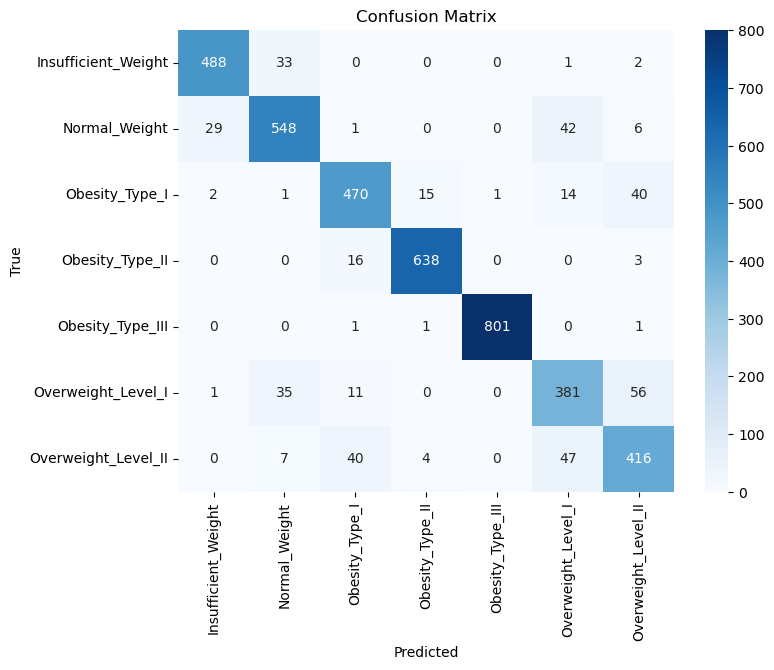

In [5]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

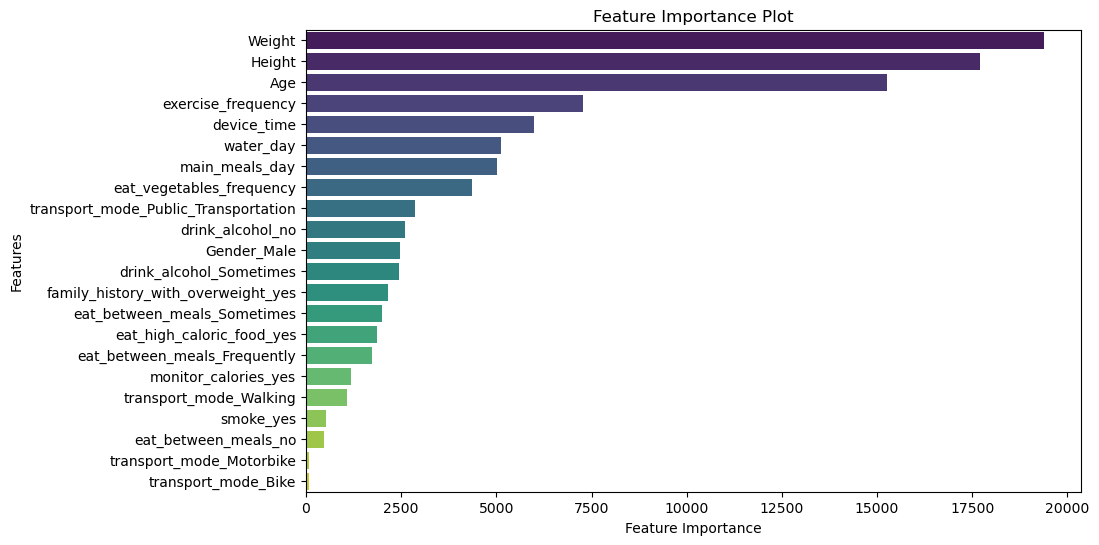

In [6]:
# Feature importance analysis
feature_importance = lgb_classifier_best.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_idx], y=X_encoded.columns[sorted_idx], palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

# Logistic Regression (05)

In [ ]:
# 3 TOM LOGISTIC REGRESSION




# Drop the target column
X = df.drop(columns=['obese_category'])
y = df['obese_category']

# Apply label encoding to all columns
label_encoder = LabelEncoder()
X_encoded = X.apply(label_encoder.fit_transform)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Define and train logistic regression model
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# Make predictions
y_pred = logistic_regression.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Naive Bayes Model (06)

In [ ]:
#4 AARON NAIVE BAYES



X = df.drop(columns=['obese_category', 'Gender', 'water_day', 'smoke', 'transport_mode'])
y = df['obese_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split dataset into 80/20 training

X.isnull().sum()


target_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}
X['BMI'] = X['Weight']/(X['Height']**2)

X.reset_index(drop=True, inplace=True)


# Removing outliers using Z-Scores

mean = X.mean()
std = X.std()

# Calculate the lower and upper bounds
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

# Remove data points outside of the bounds
cleaned_X = X[(X >= lower_bound) & (X <= upper_bound)]

# Perform one-hot encoding on categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the encoded data into training and testing sets
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Instantiate the Naive Bayes classifier
naive_bayes = GaussianNB()

# Train the classifier on the training data
naive_bayes.fit(X_train_encoded, y_train_encoded)

# Make predictions on the test data
y_pred_encoded = naive_bayes.predict(X_test_encoded)

# Evaluate the performance of the classifier
accuracy_encoded = accuracy_score(y_test_encoded, y_pred_encoded)
print("Accuracy (with one-hot encoding):", accuracy_encoded)

# Generate classification report
print(classification_report(y_test_encoded, y_pred_encoded))

# Random Forest (07)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy:  0.9361702127659575
Balanced Accuracy:  0.9351662059535888
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        56
           1       0.84      0.82      0.83        62
           2       0.97      0.96      0.97        78
           3       1.00      0.98      0.99        58
           4       1.00      1.00      1.00        63
           5       0.86      0.88      0.87        56
           6       0.94      0.94      0.94        50

    accuracy                           0.94       423
   macro avg       0.93      0.94      0.93       423
weighted avg       0.94      0.94      0.94       423



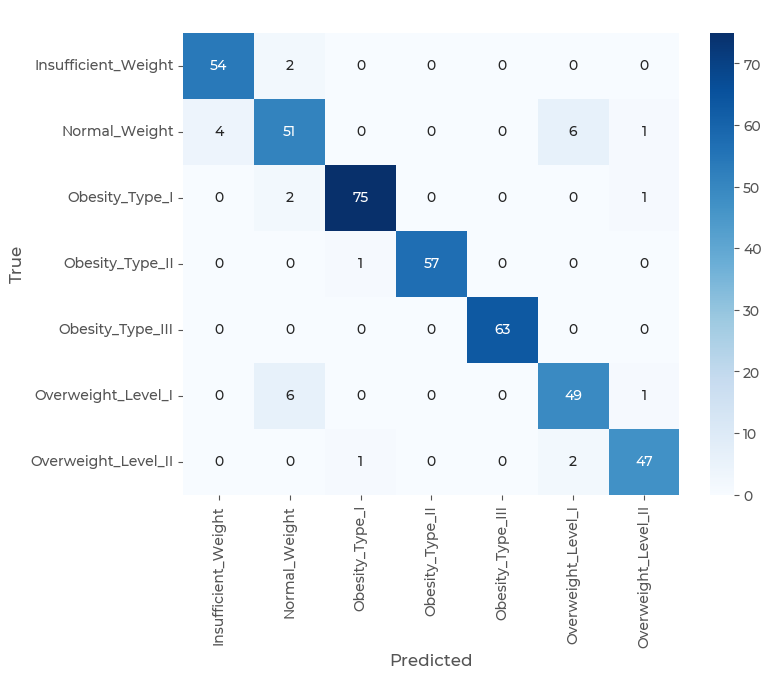

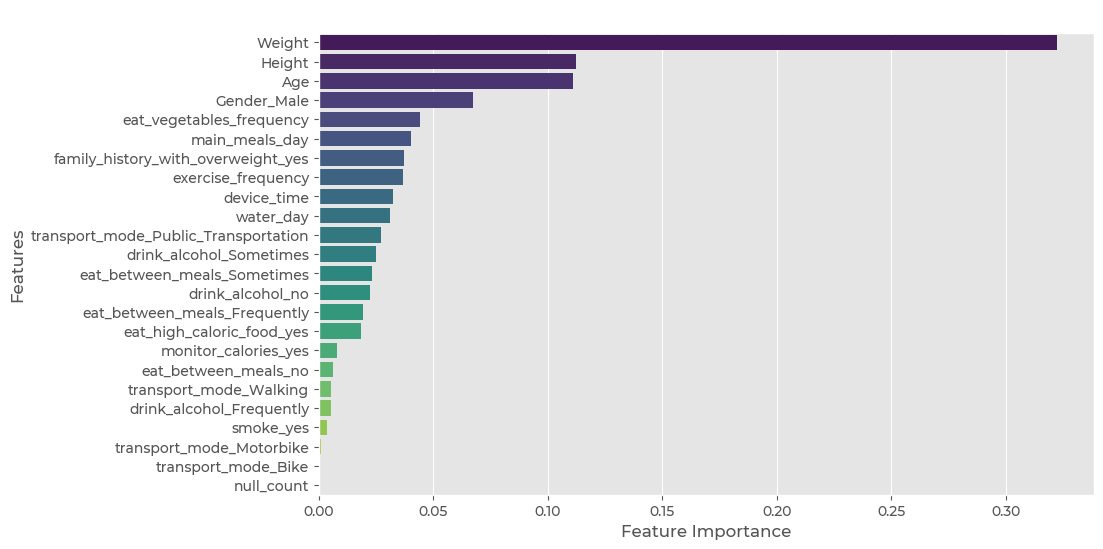

In [12]:
#RANDOM FOREST DARA




# Split features and target variable
X = df.drop(columns=['obese_category'])
y = df['obese_category']


# Apply label encoding to the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Apply one-hot encoding to categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)


# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters found during grid search
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train RandomForestClassifier with best parameters
rf_classifier_best = RandomForestClassifier(**best_params, random_state=42)
rf_classifier_best.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf_classifier_best.predict(X_test)



# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy: ", balanced_accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importance analysis
feature_importance = rf_classifier_best.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_idx], y=X_encoded.columns[sorted_idx], palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()
